# IST652 Project
# Analyzing the Relationship Between Spotify Popularity and Last.fm Play Counts

## Group 7: Leonardo Pena Jaramillo, Nikki Shimao, Wan-Hsin Hu

We install needed package. (spotipy, requests, statsmodels)

In [1]:
!pip install spotipy requests statsmodels

In [2]:
import requests 
import pandas as pd
import time 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

### Fetch data from Last.fm

In [3]:
# We connect our API from Last.fm (use API_key and BASE_URL)
API_KEY = "3eeaa17247ff1b4c3f2801474c5a30b9"
BASE_URL = "http://ws.audioscrobbler.com/2.0/"

In [4]:
# We fetch top 10 for testing if API works
# We define the endpoint and the parameters we are going to use for the API request
params = {
    "method": "chart.getTopTracks",
    "api_key": API_KEY,
    "format": "json",
    "limit": 10,
    "page": 1
}

try:
    # Once we have the parameters ready, we make the request to the API
    response = requests.get(BASE_URL, params=params)
    
    # We are parsing into a JSON response
    data = response.json()

    # We are extracting the top tracks from the response
    top_tracks = data.get("tracks", {}).get("track", [])
    
    # We are printing all the main details from the top tracks
    print("Top Tracks on Last.fm:")
    for idx, track in enumerate(top_tracks, start=1):  
        # Extract relevant track details
        name = track.get("name", "Unknown")  
        artist = track.get("artist", {}).get("name", "Unknown")  
        playcount = track.get("playcount", "Unknown")  
        listeners = track.get("listeners", "Unknown") 
        url = track.get("url", "#")  
        
        print(f"{idx}. {name} by {artist}")
        print(f"   Playcount: {playcount}, Listeners: {listeners}")
        print(f"   URL: {url}")
        print("-" * 40)
# We are adding and error nessage to try the code and see if it works
except requests.exceptions.RequestException as e:
    print("Error fetching data:", e)

Top Tracks on Last.fm:
1. squabble up by Kendrick Lamar
   Playcount: 3867892, Listeners: 635012
   URL: https://www.last.fm/music/Kendrick+Lamar/_/squabble+up
----------------------------------------
2. Good Luck, Babe! by Chappell Roan
   Playcount: 34022842, Listeners: 1381212
   URL: https://www.last.fm/music/Chappell+Roan/_/Good+Luck,+Babe%21
----------------------------------------
3. BIRDS OF A FEATHER by Billie Eilish
   Playcount: 30542739, Listeners: 1456968
   URL: https://www.last.fm/music/Billie+Eilish/_/BIRDS+OF+A+FEATHER
----------------------------------------
4. wacced out murals by Kendrick Lamar
   Playcount: 2486786, Listeners: 566258
   URL: https://www.last.fm/music/Kendrick+Lamar/_/wacced+out+murals
----------------------------------------
5. luther (with SZA) by Kendrick Lamar
   Playcount: 3846694, Listeners: 535309
   URL: https://www.last.fm/music/Kendrick+Lamar/_/luther+(with+SZA)
----------------------------------------
6. espresso by Sabrina Carpenter
   P

### Data preparation: Top 50 Tracks
we fetch top 50 tracks from Last.fm

In [5]:
# We are defining the parameters to fetch the global top tracks (we set the code for 50. The limit of this API is 100)
params = {
    "method": "chart.getTopTracks",
    "api_key": API_KEY,
    "format": "json",
    "limit": 50  
}

# we are making the request to the API
response = requests.get(BASE_URL, params=params)
response.raise_for_status()
data = response.json()

# we are extracting not only the tracks but also the playcounts of each of them
tracks = data.get("tracks", {}).get("track", [])
track_data = []

for track in tracks:
    name = track.get("name", "Unknown")
    artist = track.get("artist", {}).get("name", "Unknown")
    playcount = int(track.get("playcount", 0))
    listeners = int(track.get("listeners", 0))  # Extract listeners
    genre = "Unknown Genre"  # Placeholder for genre
    track_data.append({"Track": name, "Artist": artist, "Playcount": playcount, "Listeners": listeners, "Genre": genre})

# We are fetching the genres for an artist to be used for ordering artists based on the genres they belong to
def get_genre(artist_name):
    genre_params = {
        "method": "artist.getInfo",
        "artist": artist_name,
        "api_key": API_KEY,
        "format": "json"
    }
    try:
        response = requests.get(BASE_URL, params=genre_params)
        response.raise_for_status()
        artist_data = response.json()
        tags = artist_data.get("artist", {}).get("tags", {}).get("tag", [])
        # we are extracting the first tag as the genre
        if tags:
            return tags[0].get("name", "Unknown Genre")
    except Exception as e:
        print(f"Error fetching genre for {artist_name}: {e}")
    return "Unknown Genre"

# We are adding the genre to the data 
for track in track_data:
    artist = track["Artist"]
    track["Genre"] = get_genre(artist)
    time.sleep(0.2)  

# We are making a dataframe of the Top tracks 
df = pd.DataFrame(track_data)

# We are saving the enriched data to a file so we can use later for the analysis, this file contain all top 50 songs in order with the name of the artist, the playcount and the genre
df.to_csv("top_tracks_including_genre.csv", index=False)

### Question 1: Which music genres have the highest total play counts among the top 50 tracks globally?

In [6]:
# we load our dataframe
df = pd.read_csv("top_tracks_including_genre.csv")

# we group and filter the genres with the plaoycount of the Top 50 Tracks to see what is the most played genre 
genre_summary = df.groupby("Genre")["Playcount"].sum().reset_index()
genre_summary = genre_summary.sort_values(by="Playcount", ascending=False)

# we save into a csv the result
genre_summary.to_csv("top_genres_by_playcounts.csv", index=False)
print("Top Genres Globally by Play Counts:")
print(genre_summary)


Top Genres Globally by Play Counts:
        Genre  Playcount
6         pop  317144301
1     Hip-Hop  141461050
7         rnb  108972322
8   seen live   42057308
5  indie rock   38667702
3       indie   35031240
4   indie pop   32664605
0         80s   11181774
2        folk    9423132


### Question 2: Who are the most dominant artists in Last.fm’s Top 50 global tracks, and how do these artists vary across different music genres?

In [7]:
# we now group and filter the artists with the amount of top tracks they have in the Top 50 
artist_summary = df.groupby("Artist").size().reset_index(name="Track Count")
artist_summary = artist_summary.sort_values(by="Track Count", ascending=False)

# we save into a csv the result 
artist_summary.to_csv("top_artists_globally.csv", index=False)
print("\nArtist with Most Top Tracks Globally:")
print(artist_summary)


Artist with Most Top Tracks Globally:
                Artist  Track Count
7       Kendrick Lamar           13
17  Tyler, the Creator            9
13   Sabrina Carpenter            5
2        Chappell Roan            3
3           Charli XCX            3
1        Billie Eilish            3
0       Arctic Monkeys            1
12                 SZA            1
18               Wham!            1
16          The Weeknd            1
15   The Neighbourhood            1
14             TV Girl            1
10              Mitski            1
11                Rosé            1
9         Mariah Carey            1
8            Lady Gaga            1
6        Gracie Abrams            1
5           Gigi Perez            1
4          Frank Ocean            1
19      pinkpantheress            1


In [8]:
# we group all the genres with their Top Artist from the Top 50 list
top_artists_per_genre = (
    df.groupby("Genre")
    .apply(lambda group: group.groupby("Artist").size().sort_values(ascending=False).idxmax())
    .reset_index()
    .rename(columns={0: "Top Artist"})
)
#we save into a csv the result
top_artists_per_genre.to_csv("top_artists_per_genre.csv", index=False)
print("\nUpdated Top Artist per Genre:")
print(top_artists_per_genre)


Updated Top Artist per Genre:
        Genre         Top Artist
0         80s              Wham!
1     Hip-Hop     Kendrick Lamar
2        folk         Gigi Perez
3       indie  The Neighbourhood
4   indie pop            TV Girl
5  indie rock     Arctic Monkeys
6         pop  Sabrina Carpenter
7         rnb        Frank Ocean
8   seen live      Gracie Abrams


### Question 3: Is there any relationship between Last.fm playcount and Spotify Popularity score?

#### First, we performs an analysis based on the Top 50.

In [9]:
# Set Spotify credentials (Spotify Web API use client_id and client_secret, different from Last.lm)
client_credentials_manager = SpotifyClientCredentials(
    client_id='b63d12cad7b44c7fb809d89be4feadba',
    client_secret='8bd542f83f234d3996a2b8b65464320f'
)

# We set 'sp' for API usage
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [10]:
# Fetch Spotify Track Details
def fetch_spotify_track_details(track_name, artist_name):
    """Search for a track on Spotify and fetch its details."""
    query = f"track:{track_name} artist:{artist_name}"
    results = sp.search(q=query, type="track", limit=1)
    if results['tracks']['items']:
        track = results['tracks']['items'][0]
        return {
            "popularity": track.get("popularity", 0),
            "markets": track.get("available_markets", [])
        }
    return {"popularity": 0, "markets": []}

# Combine Last.fm Data (`df`) with Spotify Data
def combine_with_spotify(df):
    """Merge Last.fm data with Spotify details."""
    comparison_data = []
    for _, track in df.iterrows():
        spotify_details = fetch_spotify_track_details(track["Track"], track["Artist"])
        comparison_data.append({
            "Track Name": track["Track"],
            "Artist": track["Artist"],
            "Playcount": track["Playcount"],
            "Listeners": track["Listeners"],
            "Popularity": spotify_details["popularity"],
        })
    return pd.DataFrame(comparison_data)

# Use the existing `df` and merge it with Spotify data
comparison_data = combine_with_spotify(df)

In [11]:
# we save the new merged data (Last.fm top 50 with Sportfy Popularity) into a CSV
comparison_data.to_csv("lastfm_spotify_top_tracks.csv", index=False)

print("Combined Last.fm and Spotify Data:")
print(comparison_data)

Combined Last.fm and Spotify Data:
                                        Track Name              Artist  \
0                                      squabble up      Kendrick Lamar   
1                                 Good Luck, Babe!       Chappell Roan   
2                               BIRDS OF A FEATHER       Billie Eilish   
3                                wacced out murals      Kendrick Lamar   
4                                luther (with SZA)      Kendrick Lamar   
5                                         espresso   Sabrina Carpenter   
6                                man at the garden      Kendrick Lamar   
7                                             APT.                Rosé   
8                 See You Again (feat. Kali Uchis)  Tyler, the Creator   
9                                     Reincarnated      Kendrick Lamar   
10                    tv off (feat. Lefty Gunplay)      Kendrick Lamar   
11                                           tAsTe   Sabrina Carpenter   
12 

In [12]:
# Since these columns is str, we have to cast them into int
comparison_data["Playcount"] = comparison_data["Playcount"].astype(int)
comparison_data["Popularity"] = comparison_data["Popularity"].astype(int)
comparison_data["Listeners"] = comparison_data["Listeners"].astype(int)

In [13]:
# we prepare the data we are going to use for the regression 
X = comparison_data["Popularity"]  
y = comparison_data["Playcount"]  

# we add a constant to the model
X = sm.add_constant(X)

# regression model
model = sm.OLS(y, X).fit()

# we extract the main details to analyse the dependency
r_squared = model.rsquared
coefficients = model.params
p_values = model.pvalues
f_statistic = model.fvalue  
f_p_value = model.f_pvalue

print(f"R-Squared: {r_squared:.4f}")
print("Coefficients:")
print(coefficients)
print("\nP-Values:")
print(p_values)
print(f"\nP-value of the model: {f_p_value:.4f}")

R-Squared: 0.0027
Coefficients:
const         2.746086e+07
Popularity   -1.448099e+05
dtype: float64

P-Values:
const         0.439481
Popularity    0.719083
dtype: float64

P-value of the model: 0.7191


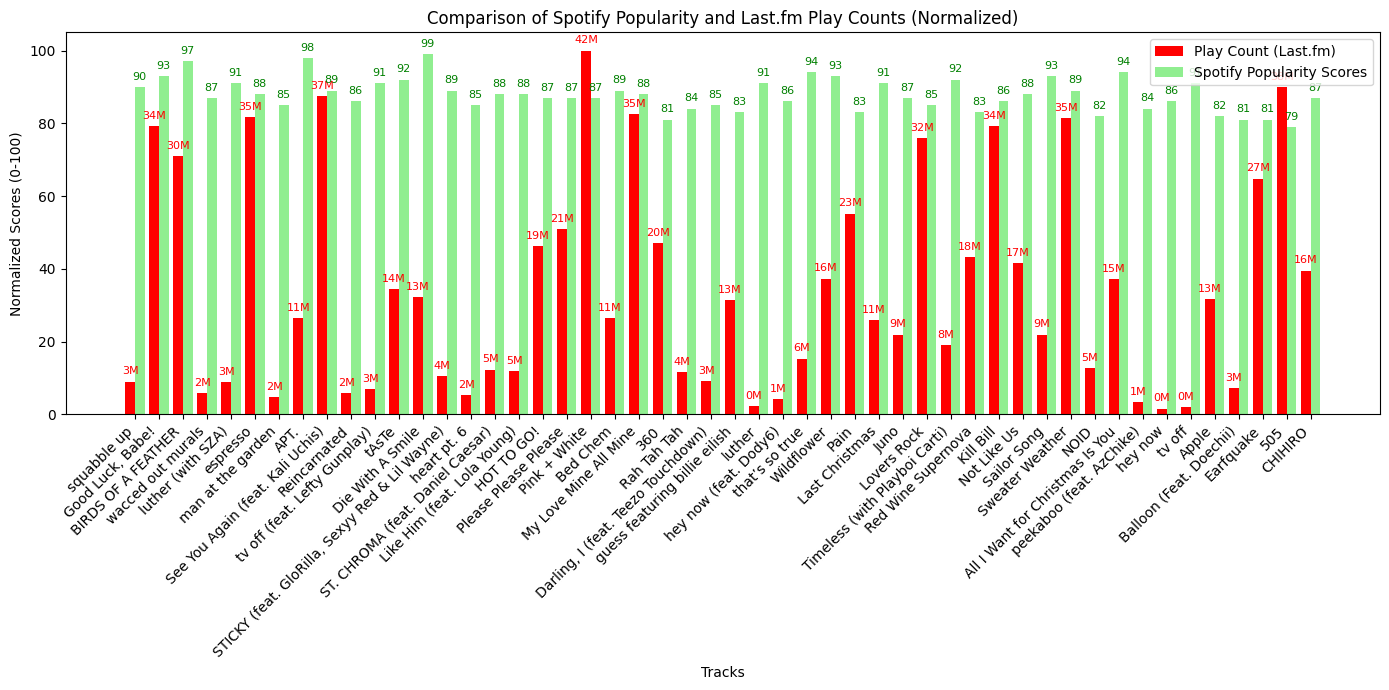

In [14]:
# we are normalizing the playcounts to 0-100, in this way we can have side by side the comparison between the Playcount and the Popularity score
comparison_data = comparison_data.dropna(subset=['Popularity', 'Playcount'])
comparison_data.loc[:, "Normalized Playcount"] = (
    comparison_data["Playcount"] / comparison_data["Playcount"].max() * 100
)

# Plot settings
track_names = comparison_data["Track Name"]
x = np.arange(len(track_names))  # X-axis positions
width = 0.4  # Bar width

# we create the barchart
fig, ax = plt.subplots(figsize=(14, 7))

# Bars for normalized play counts
bar1 = ax.bar(x - width/2, comparison_data["Normalized Playcount"], width, label="Play Count (Last.fm)", color="red")

# Bars for Spotify popularity
bar2 = ax.bar(x + width/2, comparison_data["Popularity"], width, label="Spotify Popularity Scores", color="lightgreen")

# Annotate play counts (actual values in millions) above bars
for i, (playcount, popularity) in enumerate(zip(comparison_data["Playcount"], comparison_data["Popularity"])):
    ax.text(x[i] - width/2, comparison_data["Normalized Playcount"].iloc[i] + 2, f"{playcount // 1_000_000}M", ha="center", fontsize=8, color="red")
    ax.text(x[i] + width/2, comparison_data["Popularity"].iloc[i] + 2, f"{popularity}", ha="center", fontsize=8, color="green")

# extra customization for the chart
ax.set_xlabel("Tracks")
ax.set_ylabel("Normalized Scores (0-100)")
ax.set_title("Comparison of Spotify Popularity and Last.fm Play Counts (Normalized)")
ax.set_xticks(x)
ax.set_xticklabels(track_names, rotation=45, ha="right")
ax.legend()

# plot barchart
# save the chart
plt.savefig('comparison_bar_popularity_and_playcounts.png', format='png', dpi=100, bbox_inches='tight')

# show in output
plt.tight_layout()
plt.show()

It is not significantly related. So, we consider if listeners can do with the relationship. (test it later)

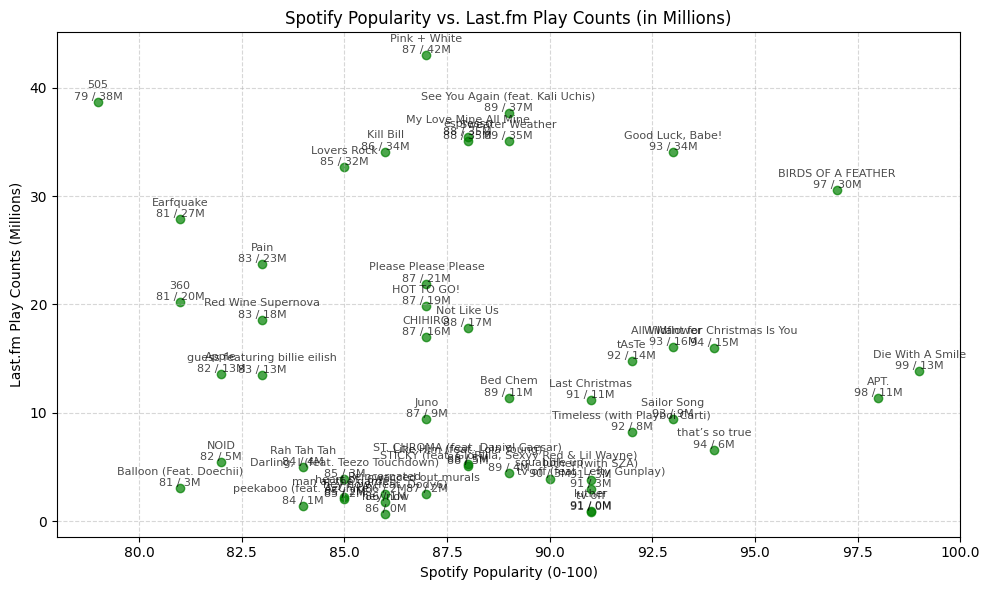

In [15]:
#we created a scatter plot to show better if there was any relationship between playcount and popularity 
plt.figure(figsize=(10, 6))

# we create the scatter points
plt.scatter(
    comparison_data["Popularity"],
    comparison_data["Playcount"] / 1_000_000,  
    color="green",
    alpha=0.7
)

# we customize the labels
plt.title("Spotify Popularity vs. Last.fm Play Counts (in Millions)")
plt.xlabel("Spotify Popularity (0-100)")
plt.ylabel("Last.fm Play Counts (Millions)")

# Annotate each point with track names
for i, row in comparison_data.iterrows():
    plt.annotate(
        f"{row['Track Name']}\n{row['Popularity']} / {row['Playcount'] // 1_000_000}M",
        (row["Popularity"], row["Playcount"] / 1_000_000),
        fontsize=8,
        alpha=0.7,
        ha="center",
        va="bottom"
    )

# we add a grid to the background
plt.grid(True, linestyle="--", alpha=0.5)

# save the chart
plt.savefig('comparison_scatter_popularity_and_playcounts.png', format='png', dpi=100, bbox_inches='tight')

plt.tight_layout()
plt.show()

#### Let's explore if for a specific artist we have a relationship.

In [16]:
# We again define the endpoint and the parameters we are going to use for the API request but this time for a specific artist in this case we used Bruno Mars
params = {
    "method": "artist.getTopTracks",  
    "artist": "Bruno Mars",  
    "api_key": API_KEY,
    "format": "json",
    "limit": 10
}

try:
    # Once we have the parameters ready, we make the request to the API for Bruno Mars' top tracks
    response = requests.get(BASE_URL, params=params)
    response.raise_for_status()  
    data = response.json()
    # We are extracting the top tracks for Bruno Mars
    top_tracks = data.get("toptracks", {}).get("track", [])

    # We are printing all the main details from the top tracks for Bruno Mars
    print("Top Tracks for Bruno Mars:")
    for idx, track in enumerate(top_tracks, start=1):  
        # Extract relevant track details
        name = track.get("name", "Unknown")  
        playcount = track.get("playcount", "Unknown")  
        
        print(f"{idx}. {name}")
        print(f"   Playcount: {playcount}")
        print("-" * 40)  
#we added the error message in case the artist we want to try with is not part of the API
except requests.exceptions.RequestException as e:
    print("Error fetching data:", e)

Top Tracks for Bruno Mars:
1. Locked Out of Heaven
   Playcount: 17383335
----------------------------------------
2. Just the Way You Are
   Playcount: 13473528
----------------------------------------
3. When I Was Your Man
   Playcount: 13176832
----------------------------------------
4. Grenade
   Playcount: 11799716
----------------------------------------
5. That's What I Like
   Playcount: 10765543
----------------------------------------
6. Treasure
   Playcount: 9175395
----------------------------------------
7. The Lazy Song
   Playcount: 6639384
----------------------------------------
8. Talking to the Moon
   Playcount: 9744384
----------------------------------------
9. Leave The Door Open
   Playcount: 11509838
----------------------------------------
10. 24K Magic
   Playcount: 7233120
----------------------------------------


In [17]:
# Search for an artist
artist_name = 'Bruno Mars'  # Replace with the artist name you want to search

try:
    # Use the search API to query the artist
    result = sp.search(q=artist_name, type='artist', limit=1)
    artist = result['artists']['items'][0]
    print(f"Artist Name: {artist['name']}")
    print(f"Spotify Artist ID: {artist['id']}")
    print(f"Spotify URL: {artist['external_urls']['spotify']}")
    print(f"Genres: {', '.join(artist['genres'])}")
except IndexError:
    print(f"No artist found with the name '{artist_name}'.")
except spotipy.exceptions.SpotifyException as e:
    print(f"Error occurred while searching for the artist: {e}")

Artist Name: Bruno Mars
Spotify Artist ID: 0du5cEVh5yTK9QJze8zA0C
Spotify URL: https://open.spotify.com/artist/0du5cEVh5yTK9QJze8zA0C
Genres: dance pop, pop


In [18]:
artist_id = '0du5cEVh5yTK9QJze8zA0C'  # Artist ID for Bruno Mars

In [19]:
bruno_track_data =[]
try:
    top_tracks = sp.artist_top_tracks(artist_id)
    for track in top_tracks['tracks']:
        track_info = {
            'Track Name': track['name'],
            'Popularity': track['popularity'],  
        }
        bruno_track_data.append(track_info)
except spotipy.exceptions.SpotifyException as e:
    print(f"Error fetching top tracks: {e}")
    
bm_df = pd.DataFrame(bruno_track_data)
bm_df_sorted = bm_df.sort_values(by='Popularity', ascending=False)
print(bm_df_sorted)

             Track Name  Popularity
0      Die With A Smile          99
2  Locked out of Heaven          89
4    That's What I Like          88
5   When I Was Your Man          86
3  Just the Way You Are          85
7   Talking to the Moon          81
6               Grenade          77
1                  APT.          76
9             Marry You          76
8          It Will Rain          70


In [20]:
# we create the parameters to fetch the top tracks of Bruno Mars from the Last.fm API
params = {
    "method": "artist.getTopTracks",
    "artist": "Bruno Mars",
    "api_key": API_KEY,
    "format": "json",
    "limit": 50  
}
response = requests.get(BASE_URL, params=params)
response.raise_for_status()
lastfm_data = response.json()

# we extract just the relevant information we are going to need for the analysis
lastfm_bruno_tracks = []
for track in lastfm_data.get("toptracks", {}).get("track", []):
    name = track.get("name", "Unknown")
    playcount = int(track.get("playcount", 0))  # Ensure playcount is an integer
    lastfm_bruno_tracks.append({"Track Name": name, "Playcount": playcount})

# we convert the data we got from Last.fm into a DataFrame
lastfm_df = pd.DataFrame(lastfm_bruno_tracks)

# Rename 'Playcount' in lastfm_df to avoid conflicts after merge
#lastfm_df.rename(columns={"LastFM_Playcount": "Playcount"}, inplace=True)

# we merge the Spotify data and Last.fm data matching the names of the common songs
bruno_merged_data = pd.merge(bm_df_sorted, lastfm_df, on="Track Name", how="inner")

# we define the information we need from the merged data, ensuring that only the columns we need exist
bruno_merged_data = bruno_merged_data[["Track Name", "Popularity","Playcount"]]

# we save the new merged data into a CSV
output_path = "bruno_mars_top_tracks_sorted_by_popularity_merged.csv"
bruno_merged_data.to_csv(output_path, index=False)

bruno_merged_data

,Track Name,Popularity,Playcount
0,That's What I Like,88,10765543
1,When I Was Your Man,86,13176832
2,Just the Way You Are,85,13473528
3,Talking to the Moon,81,9744384
4,Grenade,77,11799716
5,Marry You,76,6870782
6,It Will Rain,70,6843938


In [21]:
# we prepare the data we are going to use for the regression 
X = bruno_merged_data["Popularity"]  
y = bruno_merged_data["Playcount"]  

# we add a constant to the model
X = sm.add_constant(X)

# regression model
model = sm.OLS(y, X).fit()

# we extract the main details to analyse the dependency
r_squared = model.rsquared
coefficients = model.params  
p_values = model.pvalues     
f_statistic = model.fvalue  
f_p_value = model.f_pvalue

print(f"R-Squared: {r_squared:.4f}")
print("Coefficients:")
print(coefficients)
print("\nP-Values:")
print(p_values)
print(f"\nP-value of the model: {f_p_value:.4f}")

R-Squared: 0.5699
Coefficients:
const        -1.532954e+07
Popularity    3.196829e+05
dtype: float64

P-Values:
const         0.186463
Popularity    0.049791
dtype: float64

P-value of the model: 0.0498


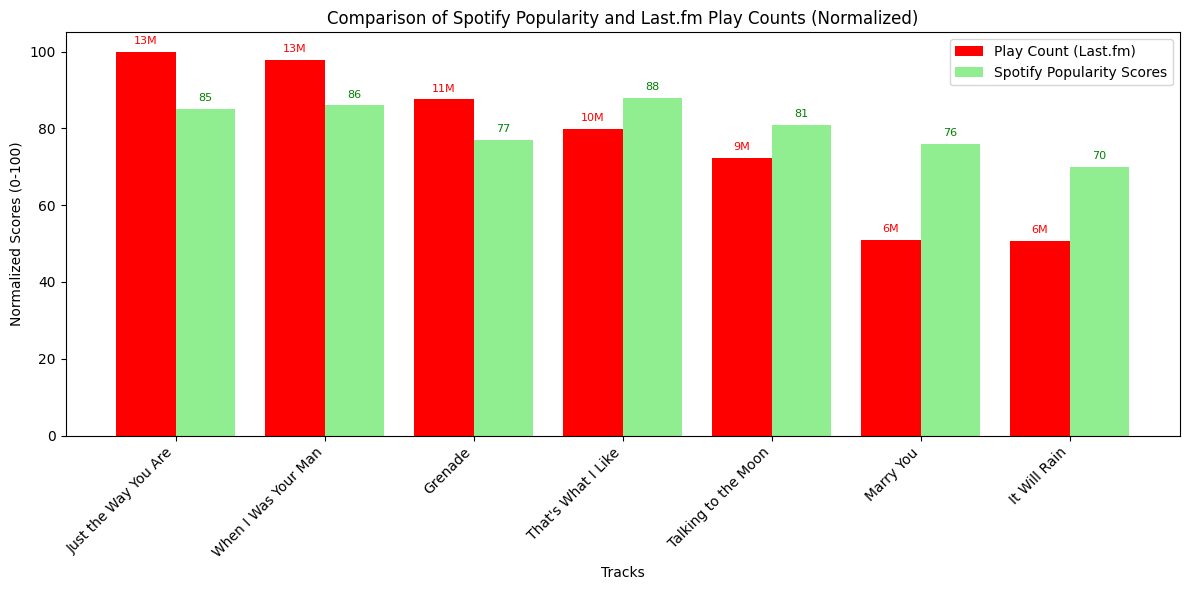

In [22]:
# we sort the data from the merged data
bruno_merged_data_sorted = bruno_merged_data.sort_values(by="Playcount", ascending=False)

# we are normalizing the playcounts to 0-100, in this way we can have side by side the comparison between the Playcount and the Popularity score
bruno_merged_data_sorted["Normalized Playcount"] = (
    bruno_merged_data_sorted["Playcount"] / bruno_merged_data_sorted["Playcount"].max() * 100
)

# Plot settings
track_names = bruno_merged_data_sorted["Track Name"]
x = np.arange(len(track_names))  
width = 0.4  

# we create the barchart
fig, ax = plt.subplots(figsize=(12, 6))

# Bars for the normalized playcounts
bar1 = ax.bar(x - width/2, bruno_merged_data_sorted["Normalized Playcount"], width, label="Play Count (Last.fm)", color="red")

# Bars for the Spotify popularity scores
bar2 = ax.bar(x + width/2, bruno_merged_data_sorted["Popularity"], width, label="Spotify Popularity Scores", color="lightgreen")

# we are adding the values of each of the songs so it can be seen that is not the same measurement 
for i, (playcount, popularity) in enumerate(zip(bruno_merged_data_sorted["Playcount"], bruno_merged_data_sorted["Popularity"])):
    ax.text(x[i] - width/2, bruno_merged_data_sorted["Normalized Playcount"].iloc[i] + 2, f"{playcount // 1_000_000}M", ha="center", fontsize=8, color="red")
    ax.text(x[i] + width/2, bruno_merged_data_sorted["Popularity"].iloc[i] + 2, f"{popularity}", ha="center", fontsize=8, color="green")

# extra customization for the chart
ax.set_xlabel("Tracks")
ax.set_ylabel("Normalized Scores (0-100)")
ax.set_title("Comparison of Spotify Popularity and Last.fm Play Counts (Normalized)")
ax.set_xticks(x)
ax.set_xticklabels(track_names, rotation=45, ha="right")
ax.legend()

# save the chart
plt.savefig('bm_bar_popularity_and_playcounts.png', format='png', dpi=100, bbox_inches='tight')

#barchart
plt.tight_layout()
plt.show()

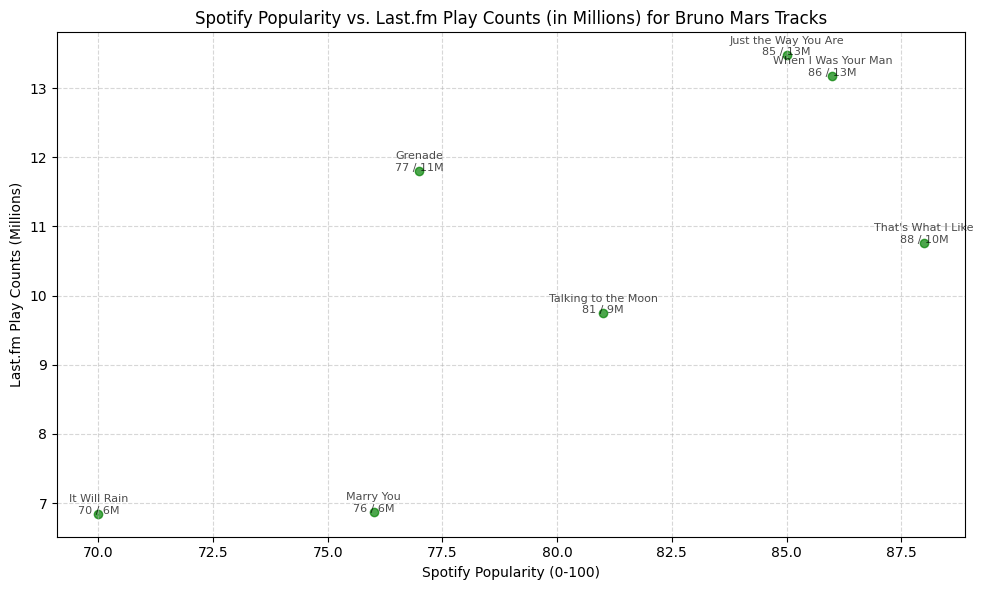

In [23]:
#we created a scatter plot to show better if there was any relationship between playcount and popularity 
plt.figure(figsize=(10, 6))

# we create the scatter points
plt.scatter(
    bruno_merged_data["Popularity"],
    bruno_merged_data["Playcount"] / 1_000_000,  
    color="green",
    alpha=0.7
)

# we customize the labels
plt.title("Spotify Popularity vs. Last.fm Play Counts (in Millions) for Bruno Mars Tracks")
plt.xlabel("Spotify Popularity (0-100)")
plt.ylabel("Last.fm Play Counts (Millions)")

# we add the number of playcount and popularity scroes to each point 
for i, row in bruno_merged_data.iterrows():
    plt.annotate(
        f"{row['Track Name']}\n{row['Popularity']} / {row['Playcount'] // 1_000_000}M",
        (row["Popularity"], row["Playcount"] / 1_000_000),
        fontsize=8,
        alpha=0.7,
        ha="center"
    )

# we add a grid to the background
plt.grid(True, linestyle="--", alpha=0.5)

# save the chart
plt.savefig('bm_scatter_popularity_and_playcounts.png', format='png', dpi=100, bbox_inches='tight')

plt.tight_layout()
plt.show()


##### It shows relationship between Spotify Popularity and Last.fm Playcount. 

# Extra tests

In [24]:
# we prepare the data we are going to use for the regression 
X = comparison_data["Listeners"]  
y = comparison_data["Playcount"]  

# we add a constant to the model
X = sm.add_constant(X)

# regression model
model = sm.OLS(y, X).fit()

# we extract the main details to analyse the dependency
r_squared = model.rsquared
coefficients = model.params
p_values = model.pvalues
f_statistic = model.fvalue  
f_p_value = model.f_pvalue

print(f"R-Squared: {r_squared:.4f}")
print("Coefficients:")
print(coefficients)
print("\nP-Values:")
print(p_values)
print(f"\nP-value of the model: {f_p_value:.20f}")

R-Squared: 0.8232
Coefficients:
const       -6.119996e+06
Listeners    2.157142e+01
dtype: float64

P-Values:
const        3.369363e-04
Listeners    1.087930e-19
dtype: float64

P-value of the model: 0.00000000000000000011


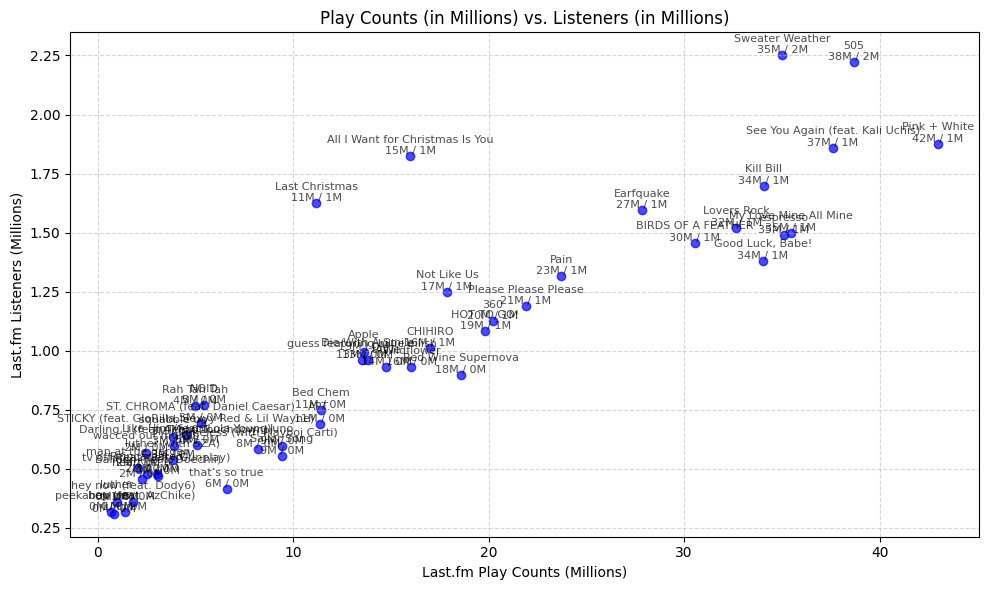

In [25]:
# We Scatter plot to show the relationship between playcount and listeners (Last.fm)
plt.figure(figsize=(10, 6))

# Create the scatter points
plt.scatter(
    comparison_data["Playcount"] / 1_000_000,  # Playcounts in millions
    comparison_data["Listeners"] / 1_000_000,  # Listeners in millions
    color="blue",
    alpha=0.7
)

# Customize the labels
plt.title("Play Counts (in Millions) vs. Listeners (in Millions)")
plt.xlabel("Last.fm Play Counts (Millions)")
plt.ylabel("Last.fm Listeners (Millions)")

# Annotate each point with track names
for i, row in comparison_data.iterrows():
    # Concatenate Playcount and Listeners values with a slash
    annotation_text = f"{row['Track Name']}\n"
    annotation_text += f"{row['Playcount'] // 1_000_000}M / {row['Listeners'] // 1_000_000}M"  # Combined annotation

    # Annotate with different colors for Playcount and Listeners
    plt.annotate(
        annotation_text,
        (row["Playcount"] / 1_000_000, row["Listeners"] / 1_000_000),
        fontsize=8,
        alpha=0.7,
        ha="center",
        va="bottom"
    )

# Add a grid to the background
plt.grid(True, linestyle="--", alpha=0.5)

# save the chart
plt.savefig('last_scatter_playcounts_and_listeners.png', format='png', dpi=100, bbox_inches='tight')

# Optimize layout
plt.tight_layout()
plt.show()

Playcounts and listeners have high dependency. (Outliner like Christmas songs. we assume Chistmas songs play by speific groups multiple times in this season). So, we use VIF to check.

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each independent variable
X = comparison_data[["Playcount", "Listeners"]]
X = sm.add_constant(X)  # Add constant
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factors:")
print(vif_data)

Variance Inflation Factors:
     Feature       VIF
0      const  5.806481
1  Playcount  5.657423
2  Listeners  5.657423


In [27]:
# we create a new variable "Playcount per Listener" to reduce the impact of multicollinearity.
comparison_data["Playcount_per_Listener"] = comparison_data["Playcount"] / comparison_data["Listeners"]

# Use Playcount_per_Listener for regression
X = comparison_data[["Playcount_per_Listener"]]
X = sm.add_constant(X)
y = comparison_data["Popularity"]

# Perform regression
model = sm.OLS(y, X).fit()

# we extract the main details to analyse the dependency
r_squared = model.rsquared
coefficients = model.params
p_values = model.pvalues
f_statistic = model.fvalue  
f_p_value = model.f_pvalue

print(f"R-Squared: {r_squared:.4f}")
print("Coefficients:")
print(coefficients)
print("\nP-Values:")
print(p_values)
print(f"\nP-value of the model: {f_p_value:.4f}")

R-Squared: 0.0078
Coefficients:
const                     87.130268
Playcount_per_Listener     0.059767
dtype: float64

P-Values:
const                     2.079741e-47
Playcount_per_Listener    5.426445e-01
dtype: float64

P-value of the model: 0.5426


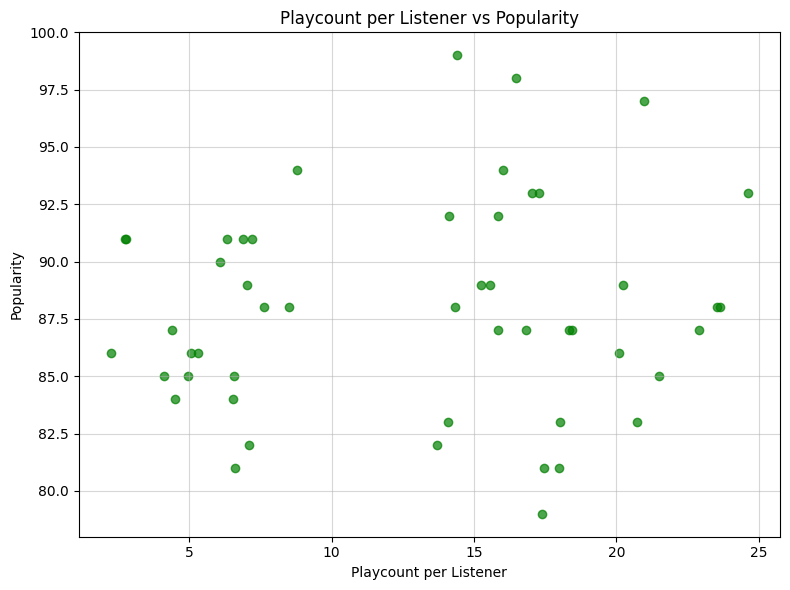

In [28]:
# Scatter plot of the new feature vs Popularity
plt.figure(figsize=(8, 6))
plt.scatter(comparison_data["Playcount_per_Listener"], y, alpha=0.7, color="green")
plt.title("Playcount per Listener vs Popularity")
plt.xlabel("Playcount per Listener")
plt.ylabel("Popularity")
plt.grid(alpha=0.5)
plt.tight_layout()

# save the chart
plt.savefig('comparison_scatter_playcountperlistener_and_listeners.png', format='png', dpi=100, bbox_inches='tight')

plt.show()

The influence of Playcount_per_Listener on Popularity is still small.